(categorical_hgf)=
# The categorical Hierarchical Gaussian Filter

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install pyhgf

In [1]:
from pyhgf.model import HGF
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
# generate some categorical inputs data using three underlying distributions
p1 = np.random.dirichlet(alpha=[1, 2, 3, 5, 9, 13, 17, 25, 30, 35])
p2 = np.random.dirichlet(alpha=[1, 2, 3, 5, 30, 30, 5, 3, 2, 1])
p3 = np.random.dirichlet(alpha=[35, 30, 25, 17, 13, 9, 5, 3, 2, 1])

input_data = np.array([np.random.multinomial(n=1, pvals=p) for p in [p1, p2, p3] for _ in range(250)]).T

In [3]:
a_custom_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="categorical", categorical_parameters={"n_categories": 10})
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


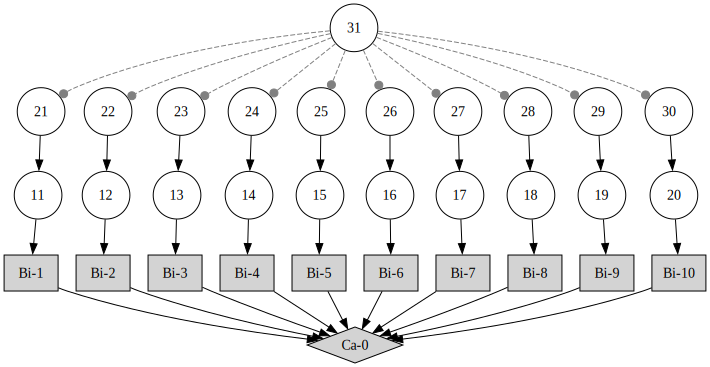

In [4]:
a_custom_hgf.plot_network()

In [5]:
input_data = np.vstack([[np.nan] * input_data.shape[1], input_data])

In [6]:
%%timeit
a_custom_hgf.input_data(input_data=input_data.T)

Adding 750 new observations.
Adding 750 new observations.
Adding 750 new observations.
Adding 750 new observations.
Adding 750 new observations.
Adding 750 new observations.
Adding 750 new observations.
Adding 750 new observations.
25 s ± 5.73 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/nicolas/git/pyhgf/pyhgf/model.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  structure_df[f"x_{i}_pihat"] = self.node_trajectories[i]["pihat"]
/home/nicolas/git/pyhgf/pyhgf/model.py:452: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  structure_df[f"x_{i}_surprise"] = np.insert(surprise, 0, np.nan)
/home/nicolas/git/pyhgf/pyhgf/model.py:432: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

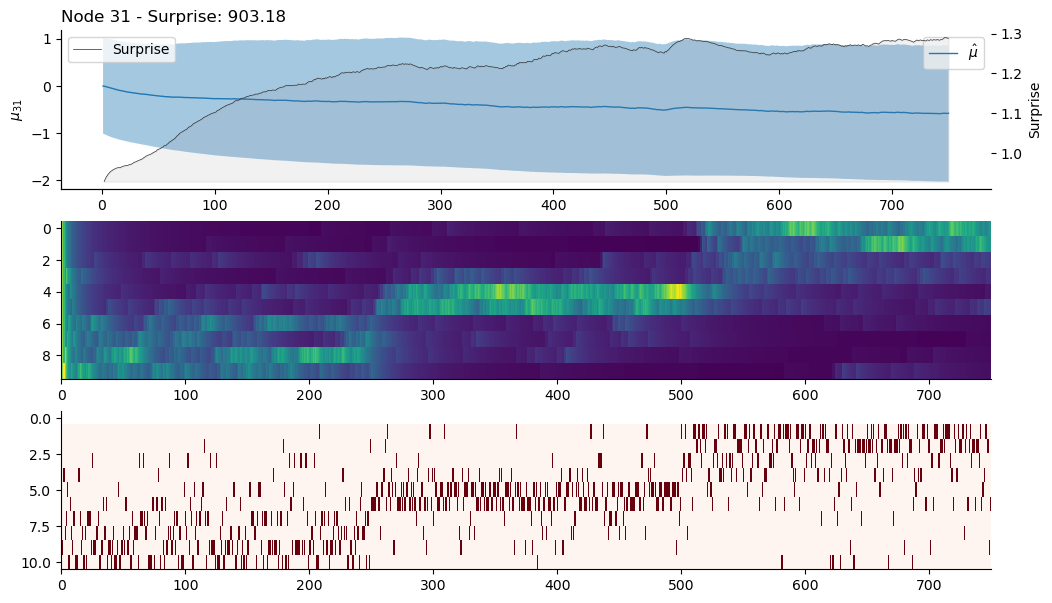

In [22]:
from pyhgf.plots import plot_nodes
import seaborn as sns

_, axs = plt.subplots(nrows=3, figsize=(12, 7))
plot_nodes(a_custom_hgf, node_idxs=31, axs=axs[0])
axs[1].imshow(a_custom_hgf.node_trajectories[0]["xi"].T, interpolation="none", aspect="auto")
axs[2].imshow(input_data, interpolation="none", aspect="auto", cmap="Reds")
sns.despine()

In [ ]:
a = "a"
ra

In [ ]:
a_custom_hgf.node_trajectories[0]["xi"]

In [7]:
a_custom_hgf.get_update_sequence()

((0, <PjitFunction of <function categorical_input_update at 0x7fc508d04c10>>),
 (1, <PjitFunction of <function binary_input_update at 0x7fc508d04550>>),
 (11, <PjitFunction of <function binary_node_update at 0x7fc508cfb8b0>>),
 (21, <PjitFunction of <function continuous_node_update at 0x7fc508cfb9d0>>),
 (2, <PjitFunction of <function binary_input_update at 0x7fc508d04550>>),
 (12, <PjitFunction of <function binary_node_update at 0x7fc508cfb8b0>>),
 (22, <PjitFunction of <function continuous_node_update at 0x7fc508cfb9d0>>),
 (3, <PjitFunction of <function binary_input_update at 0x7fc508d04550>>),
 (13, <PjitFunction of <function binary_node_update at 0x7fc508cfb8b0>>),
 (23, <PjitFunction of <function continuous_node_update at 0x7fc508cfb9d0>>),
 (4, <PjitFunction of <function binary_input_update at 0x7fc508d04550>>),
 (14, <PjitFunction of <function binary_node_update at 0x7fc508cfb8b0>>),
 (24, <PjitFunction of <function continuous_node_update at 0x7fc508cfb9d0>>),
 (5, <PjitFunctio

In [ ]:
np.array([[np.nan, 0, 1], [np.nan, 0, 1]])

In [ ]:
input_data = np.array([[np.nan, 0, 1], [np.nan, 0, 1]]).T

In [ ]:
a_custom_hgf.input_data(input_data=input_data.T)

In [ ]:
jnp.array([1/2]*5)

In [ ]:
input_data[np.newaxis, :].shape

In [ ]:
input_data = np.vstack([[np.nan] * input_data.shape[1], input_data])

In [ ]:
a_custom_hgf.attributes

In [ ]:
input_data.T

In [ ]:
input_data = np.array([[np.nan, 0, 1], [np.nan, 0, 1]]).T
a_custom_hgf.input_data(input_data=input_data.T)

In [ ]:
a = [1]
a.extend([2, 3])

In [ ]:
node_idx = 0
attributes = a_custom_hgf.attributes
edges = a_custom_hgf.edges

In [ ]:
%%timeit
[attributes[edges[vapa].value_parents[0]]["muhat"] for vapa in edges[node_idx].value_parents]

In [ ]:
# get the new expected values from the implied binary inputs
new_xi = jnp.array([attributes[edges[vapa].value_parents[0]]["muhat"] for vapa in edges[node_idx].value_parents])
new_xi

In [ ]:
current_values = jnp.array([attributes[idx]["value"] for idx in edges[node_idx].value_parents])
pe = attributes[node_idx]["xi"] - current_values
pe

In [ ]:
delta_xi = new_xi - attributes[node_idx]["xi"]
delta_xi

In [ ]:
nu = (pe / delta_xi) - 1
nu

In [ ]:
mu = nu / jnp.sum(nu)
mu

In [ ]:
attributes[node_idx]["xi"] = new_xi